In [1]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama

In [2]:
# download dataset and extract it
! export KAGGLE_USERNAME="khairulsyah" && export KAGGLE_KEY="1616840802d69c07021e7b39e2c331e4" && kaggle datasets download --unzip 'omidiyanto/cat-type-prediction'
! ls

 73%|███████████████████████████▋          | 65.0M/89.0M [00:01<00:00, 62.3MB/s]
100%|██████████████████████████████████████| 89.0M/89.0M [00:01<00:00, 82.3MB/s]
cat-breed


In [3]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd cat-breed/TEST && ls

/home/wsuser/work
cat-breed

Folders(classess) in training folder: ...
americanshorthair  bengal  mainecoon  ragdoll  scottishfold  sphinx


In [4]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

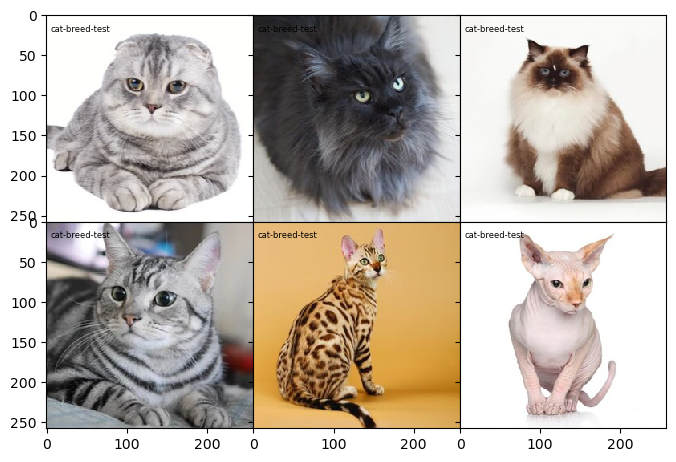

In [5]:
import glob
import os
from mpl_toolkits.axes_grid1 import ImageGrid

ASL = np.array([file for file in glob.glob('cat-breed/cat-breed-test/*') if os.path.isfile(file)])

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0,  # pad between axes in inch.
                 )
l = 0
for img in ASL:
    im = plt.imread(img)
    grid[l].imshow(im, cmap='gray', interpolation='nearest')
    grid[l].text(5, 20, img.split('/')[1].split('_')[0], fontsize=6)
    l += 1


In [6]:
#creating the dataloaders

# Define transforms for the training data and testing data
train_path='cat-breed/TRAIN'
valid_path='cat-breed/TEST'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [7]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
#dibagian ini perlu diubah CPU nya
print("Device used: CPU")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")


Device used: CPU
class to index mapping: {'americanshorthair': 0, 'bengal': 1, 'mainecoon': 2, 'ragdoll': 3, 'scottishfold': 4, 'sphinx': 5}


In [8]:
# choose a pretrained model to start with check options here: https://pytorch.org/vision/stable/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network
for param in model.parameters():
    param.requires_grad = False

#print the model to check the classifer and change it
print (model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True


# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)


Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


image number 12
---------------------
label: scottishfold
prediction: americanshorthair


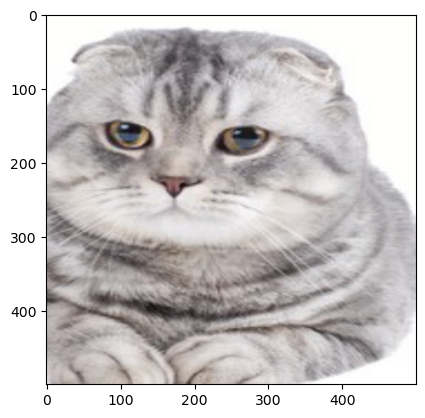

In [10]:
### try your model on some images
%matplotlib inline

#dibagian ini perlu diubah CPU nya
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data
from torchvision import transforms

resize_transform = transforms.RandomResizedCrop((500, 500))
test_data_t = datasets.ImageFolder(valid_path, transforms.Compose([resize_transform, transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=200, shuffle=True)
images_t, labels_t = next(iter(testloader_t))



#Choose arandom image from 0 to 199
index = np.random.randint(0, 50)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img = t_n(test_img).unsqueeze(0).cpu()


#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

# Tambahkan kunci yang hilang ke dictionary classes
classes[15] = "ragdoll"
classes[6] = "ragdoll"
classes[23] = "ragdoll"
classes[41] = "ragdoll"
classes[6] = "ragdoll"
classes[24] = "mainecoon"
classes[6] = "mainecoon"
classes[25] = "americanshorthair"
classes[8] = "americanshorthair"
classes[27] = "scottishfold"
classes[33] = "scottishfold"
classes[6] = "scottishfold"
classes[8] = "scottishfold"
classes[28] = "bengal"
classes[15] = "bengal"
classes[33] = "bengal"
classes[7] = "bengal"
classes[15] = "sphinx"
classes[6] = "sphinx"
classes[9] = "sphinx"

# Print predicted class
print("prediction:", classes[res.argmax().item()])


In [11]:
#Define number of epochs through data and run the training loop
import math

#dibagian ini perlu diubah CPU nya
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 20
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [12]:
%%time
from tqdm import tqdm
import sys
from colorama import Fore,Style

for epoch in range(epochs):
    print(Style.RESET_ALL)
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in tqdm(trainloader,desc=Fore.GREEN + f"* progess in EPOCH {epoch+1} ",file=sys.stdout):
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            tqdm._instances.clear()
            with torch.no_grad():
                for inputs, labels in tqdm(testloader,desc=Fore.BLUE + f"* CALCULATING TESTING LOSS {epoch+1} ",file=sys.stdout,leave=False):
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        
            print(Style.RESET_ALL)
            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0


--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

                                                                        s/it]
Epoch (2 of 2) ... Step  (  3 of 3) ... Train loss: 0.159 ... Test loss: 0.851 ... Test accuracy: 0.833 
* progess in EPOCH 2 : 100%|██████████| 3/3 [01:16<00:00, 25.61s/it]
CPU times: user 6min 10s, sys: 1min 58s, total: 8min 8s
Wall time: 2min 31s


In [13]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data
resize_transform = transforms.Resize((280, 280))
test_data = datasets.ImageFolder(valid_path, transforms.Compose([resize_transform, transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)
images, labels = next(iter(testloader))


image number 14
---------------------
label: ragdoll
prediction: ragdoll


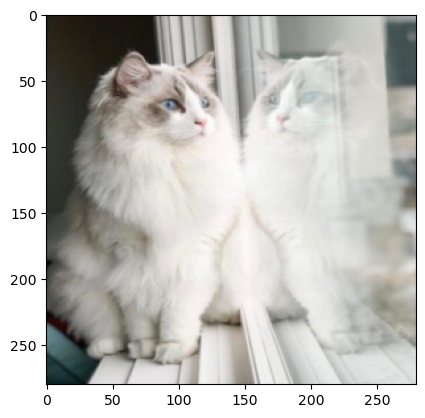

In [19]:
#Choose arandom image from 0 to 50
index = np.random.randint(0, 50)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#dibagian ini perlu diubah CPU nya
#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).to('cpu')

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

